In [1]:
import os, sys
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir,'..')))

In [2]:
from scripts.data_load import load_data
from scripts.data_visualization import *
from scripts.data_cleaning import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = load_data("../data/Data/Copy of Week2_challenge_data_source(CSV).csv")

In [4]:
columns_to_treat = ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']
data = clean_data_1(data)
data = clean_data_2(data)

Data Cleaning ...
Data Cleaning Done.


In [5]:
data_df = pd.DataFrame(data, columns=columns_to_treat)

data_df = treat_outliers_with_mean(data_df[columns_to_treat])

data = pd.DataFrame(data_df, columns=columns_to_treat).to_numpy()

In [6]:
data_df = pd.DataFrame(data, columns=columns_to_treat)

data_df['MSISDN/Number'] = range(len(data_df))

agg_data = data_df.groupby('MSISDN/Number').agg(
    avg_tcp_retrans=pd.NamedAgg(column='TCP DL Retrans. Vol (Bytes)', aggfunc='mean'),
    avg_rtt=pd.NamedAgg(column='Avg RTT DL (ms)', aggfunc='mean'),
    avg_throughput=pd.NamedAgg(column='Avg Bearer TP DL (kbps)', aggfunc='mean')
).reset_index()

In [7]:
tcp_top_10 = agg_data.nlargest(10, 'avg_tcp_retrans')
tcp_bottom_10 = agg_data.nsmallest(10, 'avg_tcp_retrans')
tcp_most_frequent = agg_data['avg_tcp_retrans'].value_counts().head(10)

In [8]:
rtt_top_10 = agg_data.nlargest(10, 'avg_rtt')
rtt_bottom_10 = agg_data.nsmallest(10, 'avg_rtt')
rtt_most_frequent = agg_data['avg_rtt'].value_counts().head(10)

In [9]:
throughput_top_10 = agg_data.nlargest(10, 'avg_throughput')
throughput_bottom_10 = agg_data.nsmallest(10, 'avg_throughput')
throughput_most_frequent = agg_data['avg_throughput'].value_counts().head(10)

In [19]:
agg_data['handset_type'] = 'Unknown'

throughput_dist = agg_data.groupby('handset_type')['avg_throughput'].mean()
tcp_retrans_dist = agg_data.groupby('handset_type')['avg_tcp_retrans'].mean()

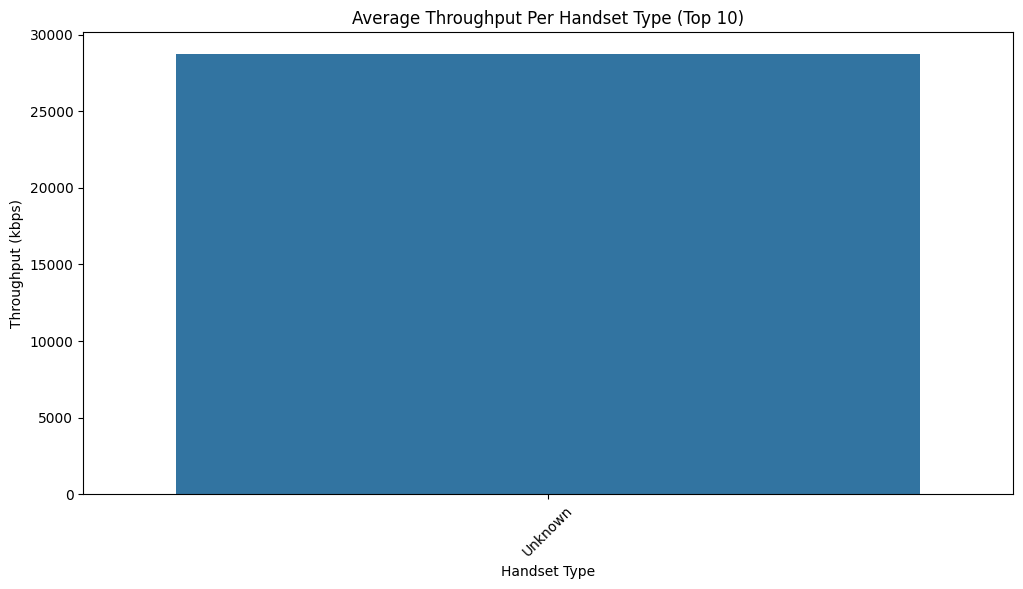

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x=throughput_dist.index[:10], y=throughput_dist.values[:10])
plt.xticks(rotation=45)
plt.title('Average Throughput Per Handset Type (Top 10)')
plt.ylabel('Throughput (kbps)')
plt.xlabel('Handset Type')
plt.show()

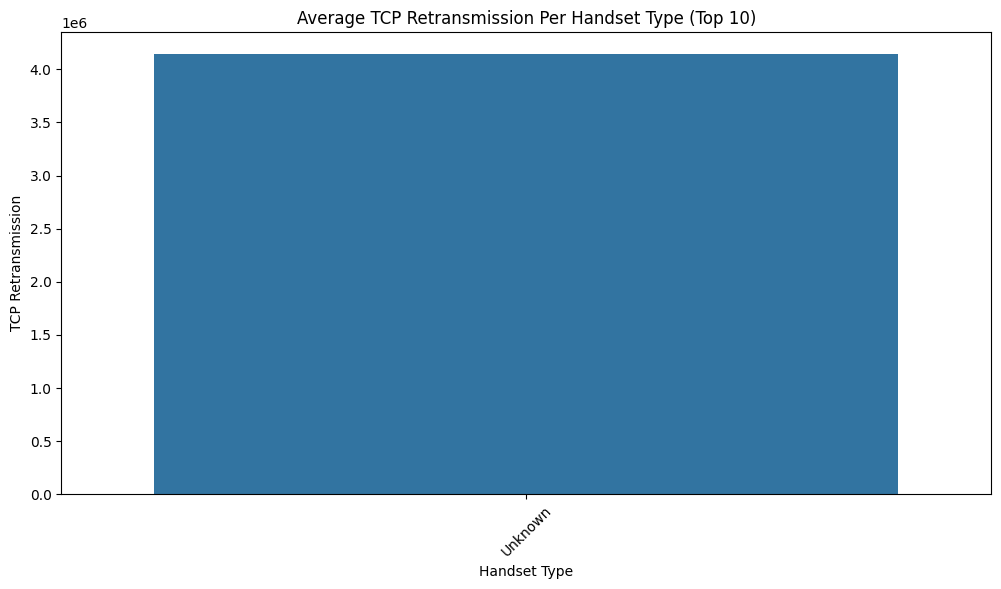

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(x=tcp_retrans_dist.index[:10], y=tcp_retrans_dist.values[:10])
plt.xticks(rotation=45)
plt.title('Average TCP Retransmission Per Handset Type (Top 10)')
plt.ylabel('TCP Retransmission')
plt.xlabel('Handset Type')
plt.show()

In [13]:
clustering_data = agg_data[['avg_tcp_retrans', 'avg_rtt', 'avg_throughput']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

kmeans = KMeans(n_clusters=3, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(scaled_data)

In [14]:
cluster_summary = agg_data.groupby('cluster').agg(
    avg_tcp_retrans=pd.NamedAgg(column='avg_tcp_retrans', aggfunc='mean'),
    avg_rtt=pd.NamedAgg(column='avg_rtt', aggfunc='mean'),
    avg_throughput=pd.NamedAgg(column='avg_throughput', aggfunc='mean'),
    count=pd.NamedAgg(column='MSISDN/Number', aggfunc='count')
)

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         avg_tcp_retrans     avg_rtt  avg_throughput  count
cluster                                                    
0           1.170529e+06   51.463638    30750.800849  40592
1           1.759257e+06  148.122662    14475.450210  12140
2           2.076001e+07   99.827135    38762.187050   8994


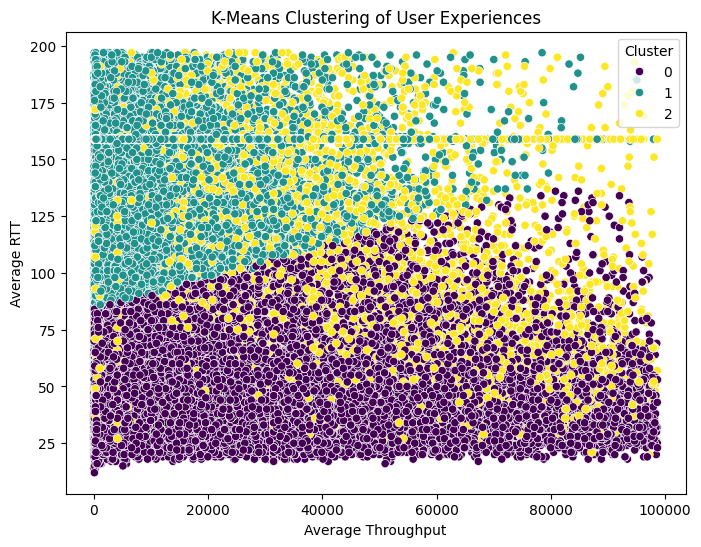

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=agg_data, x='avg_throughput', y='avg_rtt', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of User Experiences')
plt.xlabel('Average Throughput')
plt.ylabel('Average RTT')
plt.legend(title='Cluster')
plt.show()